In [1]:
# Written by Christopher Straub
# inspired from Francois Fleuret <francois@fleuret.org> code (practical3)

import math
from torch import empty
from torch import set_grad_enabled
import numpy as np
import dlc_practical_prologue as prologue

set_grad_enabled(False)

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    def backward(self, *gradwrtoutput): 
        raise NotImplementedError
    def param(self): 
        return []

In [3]:
class Linear(Module):
    """
    Implement the fully connected layer module
    """
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        # Initialisation with Xavier methods
        self.weights=empty(input_size, hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#Weight
        self.biais=empty(hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#bias
        self.grad_w = empty(input_size, hidden_size)
        self.grad_b = empty(hidden_size)
        self.next = 0
        self.previous = 0
        self.da_dw= empty(hidden_size)
        self.s=0
        self.ds_da=0
        self.begin = False
        self.last=False
    def sigma(self,x):
        out = 0
        if len(x.size())>1:#Processing for mini-batch
            one_matrix = empty(x.size(0),self.hidden_size).zero_().add(1) #we multiply the result with the batch size
            out = x.mm(self.weights)+self.biais.view(1,-1)*one_matrix #Could be optimize with broadcasting
        else : #single input
            #W*x + b
            out = self.weights.t().mv(x)+self.biais 
        return out 
    def dsigma(self,x):
        out = 0
        if len(x.size())>1:
            out = x.mm(self.weights.T)#matrix output (X (M_batch x N_input_size) * W (N input_size x hidden_size) = out (M_batch x hidden_size))
        else : 
            out = self.weights().mv(x)#vector output
        return out
    def param(self):
        return [self.weights,self.biais]
    def set_param(self,new_w,new_b):
        """
        Allow to update the parameters when we have done the optimize step calculation.
        """
        self.weights= new_w
        self.biais = new_b
    def backward(self, *gradwrtoutput):
        """"
        l(s2(a2(s1(a1(x)))))' = l'(s2(a2(s1(x))))(s2(a2(s1(x))))' = l'(s2(a2(s1(x))))(s2'(a2(s1(x))))a2'(s1(x))
        = l'(s2(a2(s1(x))))(s2'(a2(s1(x))))a2'(s1(x))s1'(a1(x))
        
        où s1(x) = s1(W_{n-1}( ... s_{1}( W_{1} x + b_{1} )+b_{n-2} )+ b_{n-1}) 
        
        dl_ds = l'(s(a(x)))
        
        ds_da = s'(a(x))
        
        dl_ds = l'(s(a(x)))(s'(a(x)))
        
        dl_dw = dl_ds * da_dw 
         
        dl_db = dl_ds * da_db
        
        """
        dl_ds = gradwrtoutput[0]
        da_dw = self.da_dw
        #da_dw contient N element de H size 
        #dl_dw la variation de la perte par rapport au poids,
        #pour la données j du batch, 
        #dl_dw = [(da_dw)_j1 * dl_ds ,(da_dw)_j2 * dl_ds,...,(da_dw)_jh * dl_ds]
        #où dl_ds est un vecteur 
        
        self.grad_w.add_( da_dw.view(da_dw.size(0),da_dw.size(1),1).matmul(dl_ds.view(dl_ds.size(0),1,dl_ds.size(1))))
        self.grad_b.add_(dl_ds)
        dl_dx = self.dsigma(dl_ds)
        
        if not(self.begin):
            self.previous.backward(dl_dx)
        
    def forward(self, *input):
        self.da_dw = input[0]
        s=self.sigma(self.da_dw)
        if not(self.last):
            s=self.next.forward(s)
        return s
    def zero_grad(self):
        self.grad_w.zero_()
        self.grad_b.zero_()
        if not(self.last):
            self.next.zero_grad()
    def init_grad(self,num_batch_size):
        self.grad_w = empty(num_batch_size,self.input_size, self.hidden_size)
        self.grad_b = empty(num_batch_size,self.hidden_size)
        if not(self.last):
            self.next.init_grad(num_batch_size)
    def get_grad(self):
        return [self.grad_w,self.grad_b]

### Activation Functions

In [4]:
class Tanh(Module):
    """
    Implement activation layer tanh
    """
    def __init__(self):
        super().__init__()
        self.ds_da = 0
        self.next = 0
        self.previous = 0
        self.begin=False
        self.last = False
        
    def sigma(self,x):
        return x.tanh()
    def dsigma(self,x):
        return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
    
    def backward(self, *gradwrtoutput):
        """"
        l(s(w(x)))' = l'(s(g(x)))(s(g(x)))' = l'(s(g(x)))(s'(g(x)))g'(x)
        
        où a(x) = W_{n} (s_{n-1} (W_{n-1}( ... s_{1}( W_{1} x + b_{1} )+b_{n-2} )+ b_{n-1} ) + b_{n}
        
        dl_dx = l'(s(a(x)))
        
        ds_da = s'(a(x))
        
        dl_ds = l'(s(a(x)))(s'(a(x)))
        
        
        """
        dl_dx = gradwrtoutput[0] 
        #1ere itération : récupéeration de la dérivée du loss evalué à l'output du net
        #autre :  
        dl_ds = self.ds_da*dl_dx #avec dérivé évalué au point du forward 
        #
        if not(self.begin):
            self.previous.backward( dl_ds)
    def forward(self, *input):
        self.ds_da = self.dsigma(input[0])#calcule de la dérivé évalué au point du forward qu'on stock pour le backward
        x=self.sigma(input[0])
        if not(self.last):
            x=self.next.forward(x)  
        return x
    def zero_grad(self):
        if not(self.last):
            self.next.zero_grad()
    def init_grad(self,num_batch_size):
        if not(self.last):
            self.next.init_grad(num_batch_size)

### Loss functions

In [5]:
class MSE(Module):
    """
    Implement the loss function Mean Square Error
    """
    def __init__(self):
        super().__init__()       
    def sigma(self,x,y):      
        return (x - y).pow(2).sum()
    def dsigma(self,x,y):   
        return 2*(x - y)
    

In [6]:
class CrossEntropy(Module):
    """
    Implement the cross entropy loss function
    """
    def __init__(self):
        super().__init__()
    def sigma(self,x,y):
        y_=y.argmax().item()
        return -(x[y_].exp().div(x.exp().sum()).log())
    def dsigma(self,x,y):
        y_=y.argmax().item()
        out= x.exp().div(x.exp().sum())
        out[y_]=1-x[y_].exp().div(x.exp().sum())
        return out 
   

### Core module

In [7]:
class Loss(Module): 
    """
    Loss has a network and a loss. 
    It uses the "sigma" method of the loss function (MSE)
    """
    def __init__(self,loss,net):
        super().__init__()
        self.net = net
        self.loss = loss
        self.acc_loss=0
        self.nb_train_errors=0
        self.backward_value = 0 # à retenir ? a voir
    def sigma(self,x,y):
        return self.loss.sigma(x,y)
    def dsigma(self,x,y):
        return self.loss.dsigma(x,y)
    def assign(self, net):
        self.net =net 
    def predict(self,x,test_target):
        """"
        just to evaluate the prediction of the network on one mini-batch
        """
        
        return (test_target.argmax(1)!=x.argmax(1)).sum(),self.loss.sigma(x, test_target).sum()

    def backward(self,*gradwrtoutput): 
        """"
        l(x) = l(f(x)) où f(x) = s_{n}( W_{n} ( ... s_{1}( W_{1} x + b_{1} ) + b_{n-1} ) + b_{n} )
        dl_dx = l'(f(x))
        
        """
        #This function call the forward method of the network for one mini-batch, and then the backward function of the network
        x = self.net.forward()#ouput of forward matrice  N x num_classes
        
    
        
        nb_train_errors,acc_loss=self.predict(x,self.net.train_target)
        self.nb_train_errors+=nb_train_errors
        self.acc_loss+=acc_loss
        
        dl_dx2 = self.dsigma(x, self.net.train_target)
        self.net.backward(dl_dx2)

In [8]:
class Net(Module):
    def __init__(self,start,end):
        super().__init__()
        self.start = start
        self.end = end
        self.train = 0
        self.train_target = []
        self.forward_value=[]
        self.num_sample = 0
    def forward(self,*input):
        out=0
        if len(input)==0:
            #dl_ds = empty(self.num_sample,self.start.input_size).zero_().add(1) 
            out = self.start.forward(self.train)
        else:
            out = self.start.forward(*input)
        return out

    def backward(self,*gradwrtoutput):
        """"
        l(x) = l(f(x)) où f(x) = s_{n}( W_{n} ( ... s_{1}( W_{1} x + b_{1} ) + b_{n-1} ) + b_{n} )
        dl_dx = l'(f(x))
        
        
        """
        
        dl_dx = gradwrtoutput[0]
        self.end.backward(dl_dx)
        
    def param(self):
        layer = self.start
        out=[]
        while(not(layer.last)):
            out.append(layer.param())
            layer = layer.next
        return out


    def set_param(self,list_parameters):
        layer = self.start
        for p in list_parameters:
            layer.set_param(p)
            layer = layer.next
            
    def get_grad(self,num_layer):
        return [self.dl_dw[num_layer],self.dl_db[num_layer]]
    def zero_grad(self):
        net.start.zero_grad()

    def assign(self, train,train_target):

        if len(train.size())>1 : 
            self.train = train
            self.train_target = train_target
            self.num_sample = train.size(0)
            self.start.init_grad(train.size(0))
 
        else : 
            self.num_sample = 1
            self.train = train
            self.train_target = train_target
            self.start.init_grad(1)



In [9]:
class SGD(Module):
    def __init__(self,lr):
        super().__init__()
        self.lr = lr
    def sigma(self,param,grad):
        
        new_w=param[0]-self.lr * grad[0].sum(0)  #en faisant que n(t,b) sot séquentielle
        new_b=param[1]-self.lr* grad[1].sum(0) 
        return new_w,new_b
            

In [10]:
class Optimizer(Module):
    def __init__(self,net,optimizer):
        super().__init__()
        self.net = net
        self.optimizer = optimizer
    def step(self):
        layer = self.net.start
        while not(layer.last):
            if len(layer.param())>0:
                new_w,new_b=self.optimizer.sigma(layer.param(),layer.get_grad()) 
                layer.set_param(new_w,new_b)
            layer=layer.next
    

In [11]:
class Sequential(Module):
    def __init__(self,*layers):
        super().__init__()
        self.num_layers = len(layers)
        for i in range(self.num_layers) : 
            if i == 0:
                layers[i].begin = True
                a = layers[i] 
            else :
                layers[i].previous = layers[i-1]
            if i<self.num_layers-1:
                layers[i].next = layers[i+1]
            else :
                layers[i].last = True  
                b = layers[i]
        self.layers=layers
        self.net = Net(a,b)
    def get_net(self):
        return self.net

In [12]:
def one_hot(a):
    num_class = a.max()+1
    N=a.size(0)
    out = empty(N,num_class).zero_()
    for i in range(N) :
        out[i][a[i]]=1 
    return out         

In [13]:


def generate_disc_set(nb):
    input = empty(nb, 2).uniform_(-1, 1 ) 
    target = input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    return input, one_hot(target)

In [14]:
from time import time


nb_train_samples=1000
nb_test_samples=1000
nb_epochs = 1000
nb_hidden = 25
eta = 1e-1 / nb_train_samples
epsilon = 1e-6


train_input, train_target = generate_disc_set(nb_train_samples)
test_input, test_target = generate_disc_set(nb_test_samples)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)



nb_classes = train_target.size(1)



net = Sequential(Linear (train_input.size(1),(nb_hidden)),Tanh()
                 ,Linear( nb_hidden,nb_hidden),Tanh()
                 ,Linear( nb_hidden,nb_hidden),Tanh()
                 ,Linear( nb_hidden,nb_hidden),Tanh()
                 ,Linear( nb_hidden,nb_classes),Tanh()).get_net()

loss = Loss(MSE(),net)
optimizer= Optimizer(net,SGD(eta))


mini_batch_size = 500
zeit = empty(nb_epochs,1000).zero_()
for e in range(nb_epochs):
    i=0
    if e==400:
        mini_batch_size=250
    if e ==500:
        mini_batch_size=500
    for b in range(0, train_input.size(0), mini_batch_size):
    # Back-prop
        net.assign(train_input.narrow(0, b, mini_batch_size),train_target.narrow(0, b, mini_batch_size))
        net.zero_grad()
        tic = time()
        loss.backward()#This function call the forward method of the network then the backward for calculating the accumulators
        toc = time()
        zeit[e][i]=(toc-tic)
        i+=1
        # Gradient step
        optimizer.step()
    # Test error
    nb_test_errors,_=loss.predict(net.forward(test_input),test_target) 
    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(e,
                  loss.acc_loss.log(),
                  (100 * loss.nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
    loss.nb_train_errors  = 0
    loss.acc_loss=0

0 acc_train_loss 6.85 acc_train_error 58.90% test_error 58.60%
1 acc_train_loss 6.46 acc_train_error 59.20% test_error 57.80%
2 acc_train_loss 6.31 acc_train_error 58.90% test_error 56.30%
3 acc_train_loss 6.25 acc_train_error 58.70% test_error 55.90%
4 acc_train_loss 6.23 acc_train_error 57.60% test_error 55.10%
5 acc_train_loss 6.22 acc_train_error 57.50% test_error 54.80%
6 acc_train_loss 6.22 acc_train_error 57.10% test_error 54.60%
7 acc_train_loss 6.22 acc_train_error 57.00% test_error 54.30%
8 acc_train_loss 6.22 acc_train_error 56.80% test_error 54.20%
9 acc_train_loss 6.22 acc_train_error 56.60% test_error 54.00%
10 acc_train_loss 6.22 acc_train_error 56.40% test_error 54.30%
11 acc_train_loss 6.21 acc_train_error 56.30% test_error 54.40%
12 acc_train_loss 6.21 acc_train_error 56.20% test_error 54.20%
13 acc_train_loss 6.21 acc_train_error 55.90% test_error 54.50%
14 acc_train_loss 6.21 acc_train_error 55.70% test_error 54.50%
15 acc_train_loss 6.21 acc_train_error 55.30% test

In [15]:
from torch import save
from torch import load
from torch import cat
import matplotlib.pyplot as plt
save(net,'./project_net_module')


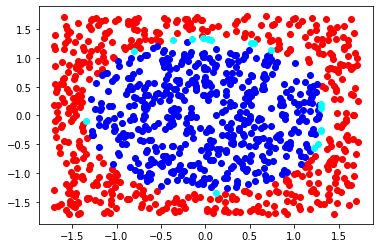

In [16]:
x = net.forward(test_input)
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero()
class1 =(test_target.argmax(1)).nonzero()
combined = cat((pred_class0, class0))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts == 1]
well_classify0 = uniques[counts > 1]
combined = cat((pred_class1, class1))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts == 1]
well_classify1 = uniques[counts > 1]

combined = cat((miss_classify0.view(-1), class0.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts > 1]

combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[well_classify1].t()[0],test_input[well_classify1].t()[1],c='red')
plt.scatter(test_input[well_classify0].t()[0],test_input[well_classify0].t()[1],c='blue')
plt.scatter(test_input[miss_classify0].t()[0],test_input[miss_classify0].t()[1],c='cyan')
plt.scatter(test_input[miss_classify1].t()[0],test_input[miss_classify1].t()[1],c='yellow')



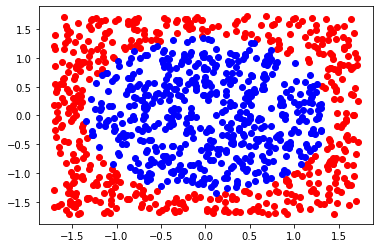

In [17]:
x = net.forward(test_input)
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero().view(-1)
class1 =(test_target.argmax(1)).nonzero().view(-1)


combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[class1].t()[0],test_input[class1].t()[1],c='red')
plt.scatter(test_input[class0].t()[0],test_input[class0].t()[1],c='blue')




In [18]:
print('moyenne des temps par backward : ',zeit.mean())
print('temps d entrainement totale : ', zeit.sum())

moyenne des temps par backward :  tensor(1.6172e-05)
temps d entrainement totale :  tensor(16.1721)
